In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd # to work with csv files

# matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

# import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stop_words

# pre-processing of text
import string
import re

# import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score

# from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

# import time function from time module to track the training duration
from time import time

### Read data

In [2]:
our_data = pd.read_csv("Full-Economic-News-DFE-839861.csv" , encoding = "ISO-8859-1" )

In [3]:
display(our_data.shape) # Number of rows (instances) and columns in the dataset
our_data["relevance"].value_counts()/our_data.shape[0] # Class distribution in the dataset

(8000, 15)

relevance
no          0.821375
yes         0.177500
not sure    0.001125
Name: count, dtype: float64

In [4]:
# convert label to a numerical variable
our_data = our_data[our_data.relevance != "not sure"] # removing the data where we don't want relevance="not sure".
print(our_data.shape)
our_data['relevance'] = our_data.relevance.map({'yes':1, 'no':0}) # relevant is 1, not-relevant is 0. 
our_data = our_data[["text","relevance"]] # Let us take only the two columns we need.
print(our_data.shape)

(7991, 15)
(7991, 2)


### Text Pre-processing

In [5]:
our_data

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1
...,...,...
7995,Secretary of Commerce Charles W. Sawyer said y...,1
7996,"U.S. stocks inched up last week, overcoming co...",0
7997,Ben S. Bernanke cleared a key hurdle Thursday ...,0
7998,The White House's push to contract out many fe...,0


In [6]:

def clean(doc): # doc is a string of text
    doc = doc.replace("</br>", " ") # This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stop_words])
    # remove punctuation and numbers
    return doc

### Modeling

    1- Split the data into training and test sets (75% train, 25% test)

    2- Extract features from the training data using CountVectorizer, which is a bag of words feature implementation. We will use the pre processing function above in conjunction with Count Vectorizer

    3- Transform the test data into the same feature vector as the training data.
    
    4- Train the classifier
    
    5- Evaluate the classifier

In [7]:
import sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Step 1: train-test split
X = our_data.text # the column text contains textual data to extract features from
y = our_data.relevance # this is the column we are learning to predict. 
print(X.shape, y.shape)
# split X and y into training and testing sets. By default, it splits 75% training and 25% test
# random_state=1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7991,) (7991,)
(5993,) (5993,)
(1998,) (1998,)


In [8]:
# Step 2-3: Preprocess and Vectorize train and test data
vect = CountVectorizer(preprocessor=clean) # instantiate a vectoriezer

#vect = CountVectorizer(analyzer='word', ngram_range=(2, 2),preprocessor=clean) # instantiate a vectoriezer


X_train_dtm = vect.fit_transform(X_train)# use it to extract features from training data
# transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)
# i.e., the dimension of our feature vector is 49753!

(5993, 49753) (1998, 49753)


In [14]:
print(vect.get_feature_names_out())
print(X_train_dtm.toarray())

['AA' 'AAA' 'AARONS' ... 'åÈlas' 'åÈn' 'åÈut']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [10]:
# Step 3: Train the classifier and predict for test data
nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm) # make class predictions for X_test_dtm

CPU times: user 11.2 ms, sys: 4.76 ms, total: 16 ms
Wall time: 14.8 ms


Accuracy:  0.7822822822822822
ROC_AOC_Score:  0.7251117679464362


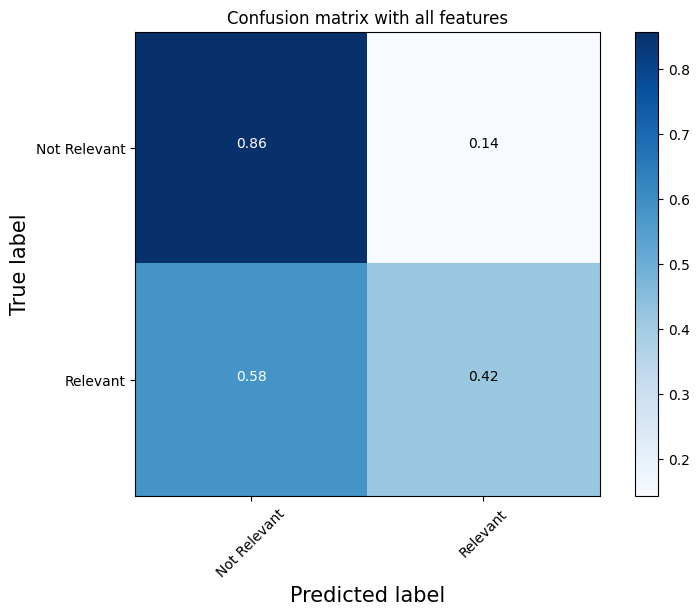

In [11]:
# Step 4: Evaluate the classifier using various measures

# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    
    
# Print accuracy:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

    
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with all features')

# calculate AUC: Area under the curve(AUC) gives idea about the model efficiency:
# Further information: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))